In [16]:
#%% Configuration Cell
import lightning as L
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchmetrics.classification import Accuracy
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os

# Configuration
PATCH_SIZE = [4, 4]
EMBED_DIM = 96
DEPTHS = [2, 2, 6, 2]
NUM_HEADS = [3, 6, 12, 24]
WINDOW_SIZE = [7, 7]
IMAGE_SIZE = 224
NUM_CLASSES = 3
BATCH_SIZE = 32
EPOCHS = 50
DATA_ROOT = "C:\\Users\\DELL 5540\\Desktop\\AI-Diagnostics-for-Predicting-Bone-Metastasis-in-Lung-Cancer-Patients-main\\archive\\The IQ-OTHNCCD lung cancer dataset"

# Paths
CHECKPOINT_PATH = os.path.join(DATA_ROOT, "checkpoints")
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

In [17]:
#%% Data Preparation Cell
# Enhanced data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = ImageFolder(
    os.path.join(DATA_ROOT, 'The IQ-OTHNCCD lung cancer dataset', 'train'),
    transform=train_transform
)

val_dataset = ImageFolder(
    os.path.join(DATA_ROOT, 'The IQ-OTHNCCD lung cancer dataset', 'val'),
    transform=val_transform
)

test_dataset = ImageFolder(
    os.path.join(DATA_ROOT, 'The IQ-OTHNCCD lung cancer dataset', 'test'),
    transform=val_transform
)

# Class names and weights
class_names = train_dataset.classes
class_counts = np.bincount(train_dataset.targets)
class_weights = 1. / class_counts
class_weights = torch.tensor(class_weights, dtype=torch.float32)

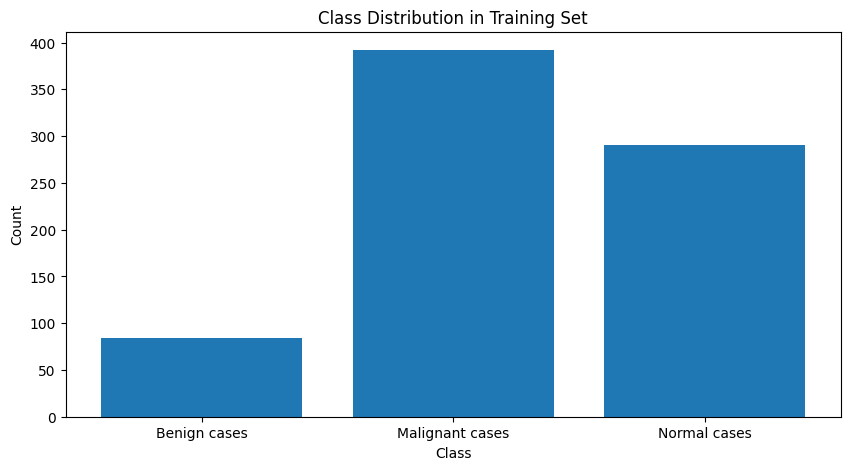

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


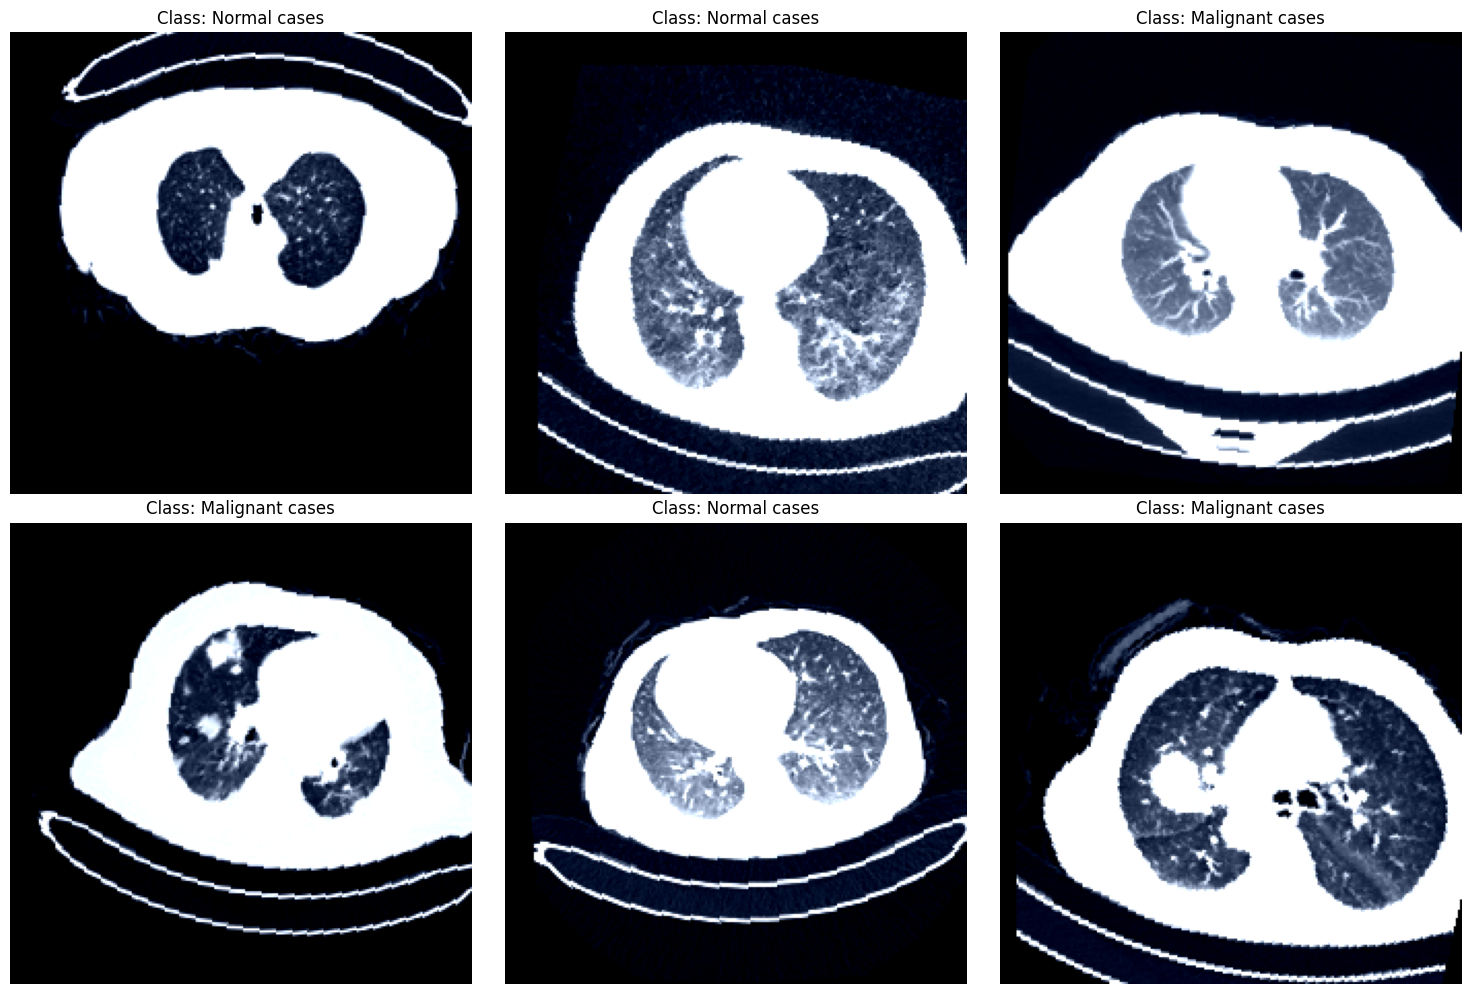

In [18]:
#%% Data Visualization Cell
def plot_class_distribution():
    counts = np.bincount(train_dataset.targets)
    plt.figure(figsize=(10, 5))
    plt.bar(class_names, counts)
    plt.title('Class Distribution in Training Set')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

def show_sample_images(dataset, num_images=6):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        idx = np.random.randint(len(dataset))
        img, label = dataset[idx]
        plt.subplot(2, 3, i+1)
        plt.imshow(img.permute(1, 2, 0).numpy() * 0.5 + 0.5)  # Unnormalize
        plt.title(f"Class: {class_names[label]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_class_distribution()
show_sample_images(train_dataset)

In [19]:
#%% Model Definition Cell
class LungCancerModel(L.LightningModule):
    def __init__(self, class_weights=None):
        super().__init__()
        # Load pretrained Swin Transformer
        self.backbone = models.swin_t(weights='DEFAULT')
        
        # Replace classification head
        self.backbone.head = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, NUM_CLASSES)
        )
        
        # Loss function with class weights
        self.criterion = nn.CrossEntropyLoss(weight=class_weights)
        
        # Metrics
        self.train_acc = Accuracy(task="multiclass", num_classes=NUM_CLASSES)
        self.val_acc = Accuracy(task="multiclass", num_classes=NUM_CLASSES)
        self.test_acc = Accuracy(task="multiclass", num_classes=NUM_CLASSES)
        
        # Track metrics
        self.train_losses = []
        self.val_losses = []
        self.train_accs = []
        self.val_accs = []

    def forward(self, x):
        return self.backbone(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.train_acc(logits.softmax(1), y)
        
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", self.train_acc, prog_bar=True)
        
        self.train_losses.append(loss.detach())
        self.train_accs.append(self.train_acc.compute().detach())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.val_acc(logits.softmax(1), y)
        
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_acc, prog_bar=True)
        
        self.val_losses.append(loss.detach())
        self.val_accs.append(self.val_acc.compute().detach())

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.test_acc(logits.softmax(1), y)
        self.log("test_loss", loss)
        self.log("test_acc", self.test_acc)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=1e-4, weight_decay=0.01)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', patience=2, factor=0.5
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_acc"
            }
        }

In [20]:
#%% Training Setup Cell
model = LungCancerModel(class_weights=class_weights)

callbacks = [
    ModelCheckpoint(
        dirpath=CHECKPOINT_PATH,
        filename="best-model-{epoch}-{val_acc:.2f}",
        monitor="val_acc",
        mode="max",
        save_top_k=3
    ),
    EarlyStopping(
        monitor="val_acc",
        patience=10,
        mode="max",
        min_delta=0.01
    ),
    LearningRateMonitor()
]

trainer = Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=EPOCHS,
    callbacks=callbacks,
    log_every_n_steps=10,
    enable_progress_bar=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=4,
    persistent_workers=True
)

Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to C:\Users\DELL 5540/.cache\torch\hub\checkpoints\swin_t-704ceda3.pth
100%|██████████| 108M/108M [01:34<00:00, 1.20MB/s] 
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [21]:
#%% Training Execution Cell
trainer.fit(model, train_loader, val_loader)
best_model = LungCancerModel.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path,
    class_weights=class_weights
)

C:\Users\DELL 5540\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory C:\Users\DELL 5540\Desktop\AI-Diagnostics-for-Predicting-Bone-Metastasis-in-Lung-Cancer-Patients-main\archive\The IQ-OTHNCCD lung cancer dataset\checkpoints exists and is not empty.

  | Name      | Type               | Params
-------------------------------------------------
0 | backbone  | SwinTransformer    | 27.7 M
1 | criterion | CrossEntropyLoss   | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | val_acc   | MulticlassAccuracy | 0     
4 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
27.7 M    Trainable params
0         Non-trainable params
27.7 M    Total params
110.868   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

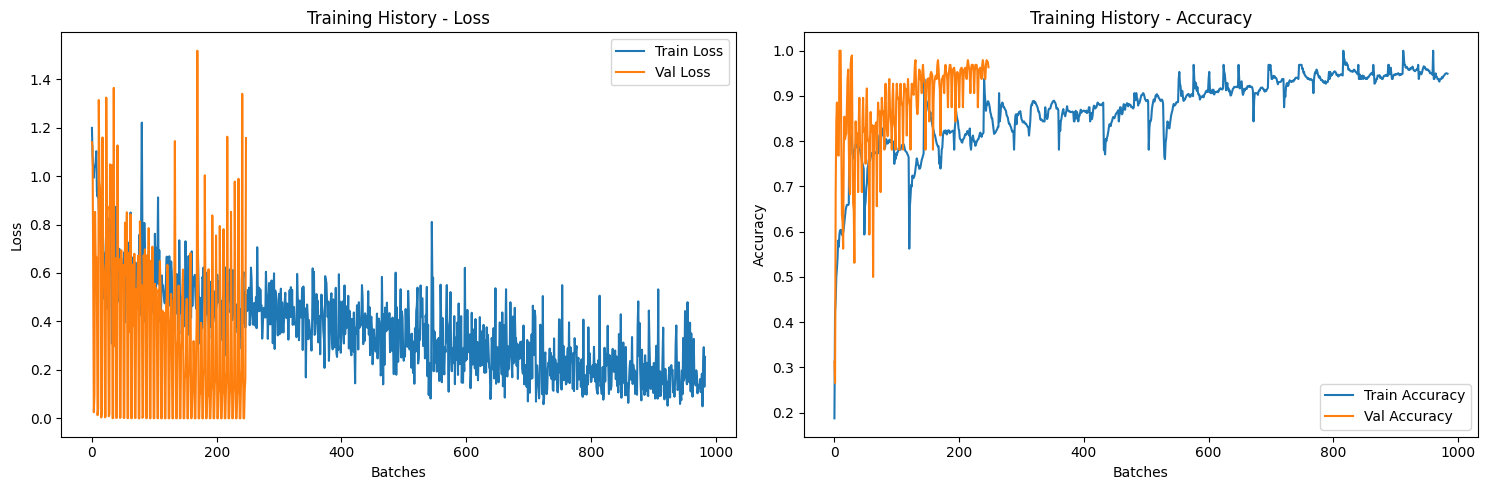

In [22]:
#%% Training Visualization Cell
def plot_training_history(model):
    plt.figure(figsize=(15, 5))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(torch.tensor(model.train_losses).cpu().numpy(), label='Train Loss')
    plt.plot(torch.tensor(model.val_losses).cpu().numpy(), label='Val Loss')
    plt.title('Training History - Loss')
    plt.xlabel('Batches')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(torch.tensor(model.train_accs).cpu().numpy(), label='Train Accuracy')
    plt.plot(torch.tensor(model.val_accs).cpu().numpy(), label='Val Accuracy')
    plt.title('Training History - Accuracy')
    plt.xlabel('Batches')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(model)

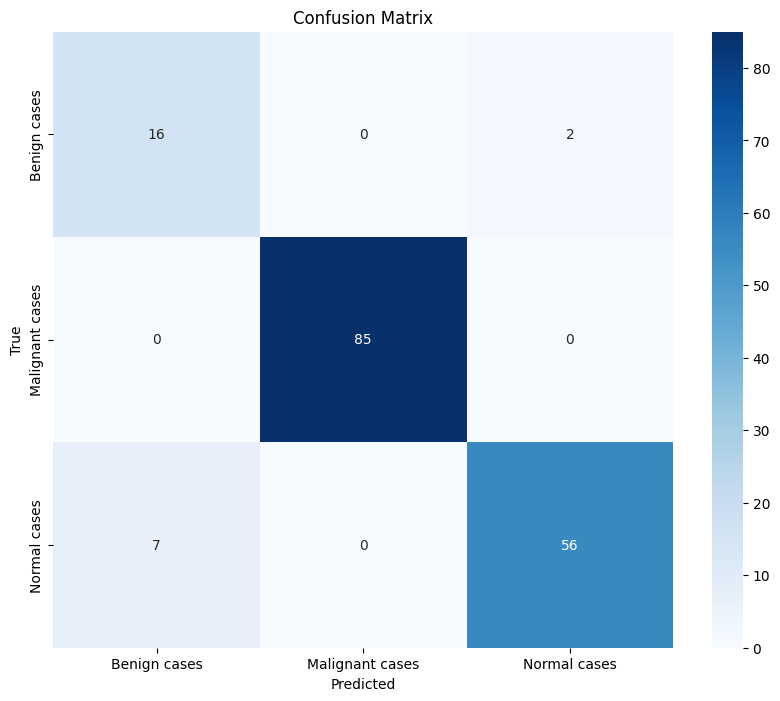

Classification Report:
                 precision    recall  f1-score   support

   Benign cases       0.70      0.89      0.78        18
Malignant cases       1.00      1.00      1.00        85
   Normal cases       0.97      0.89      0.93        63

       accuracy                           0.95       166
      macro avg       0.89      0.93      0.90       166
   weighted avg       0.95      0.95      0.95       166



In [23]:
#%% Confusion Matrix & Classification Report Cell
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
    
    # Confusion Matrix
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(all_targets, all_preds, target_names=class_names))

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=4,
    persistent_workers=True
)

evaluate_model(best_model, test_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


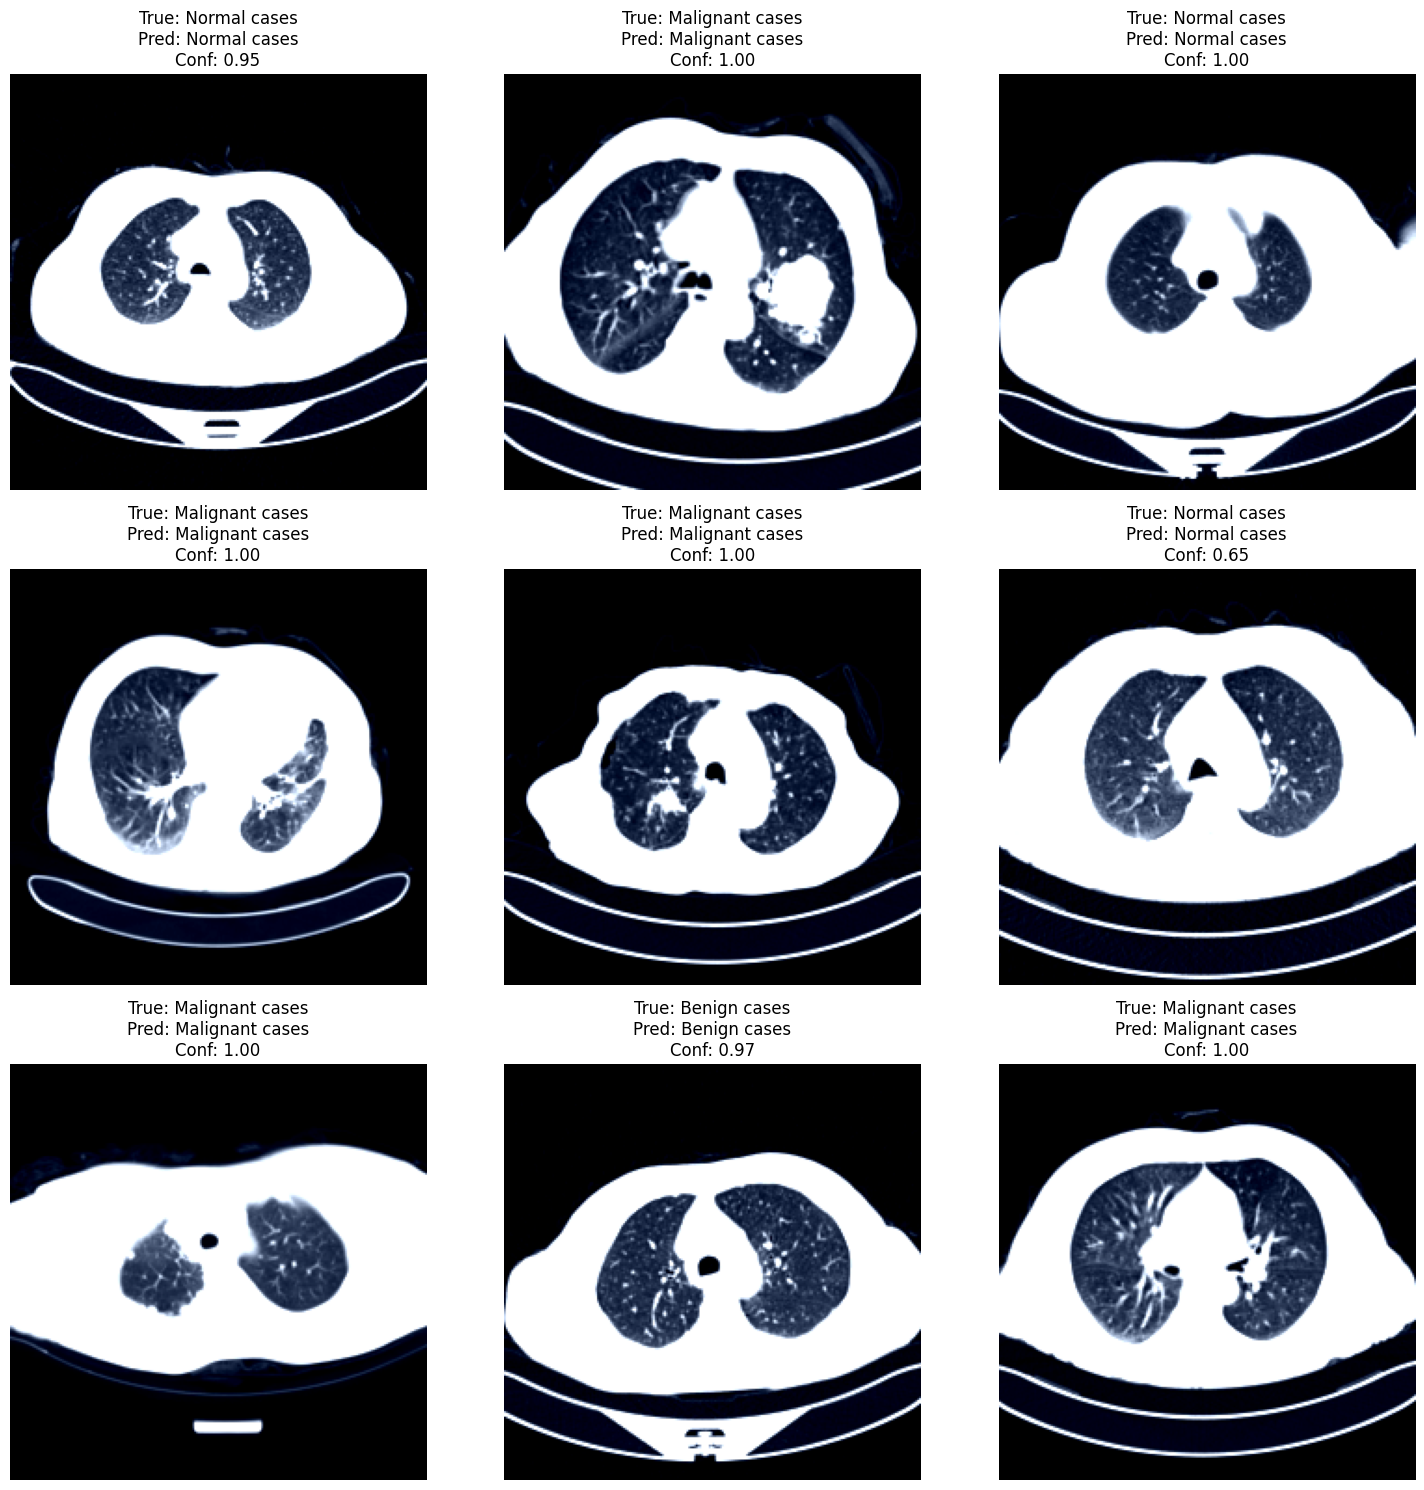

In [24]:
#%% Inference & Visualization Cell
def predict_and_visualize(model, dataset, num_images=9):
    model.eval()
    plt.figure(figsize=(15, 15))
    
    for i in range(num_images):
        idx = np.random.randint(len(dataset))
        img, true_label = dataset[idx]
        
        with torch.no_grad():
            logits = model(img.unsqueeze(0))
            probs = torch.softmax(logits, 1)
            pred_label = torch.argmax(probs).item()
        
        plt.subplot(3, 3, i+1)
        plt.imshow(img.permute(1, 2, 0).numpy() * 0.5 + 0.5)
        plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}\nConf: {probs.max().item():.2f}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

predict_and_visualize(best_model, test_dataset)